### Практическая работа №2 по дисциплине "Система для сбора событий и логов"
### Выполнил студент Благоразумов Александр Сергеевич группа ББМО-01-23
Вариант 8. Linux.

### Клонирование репозитория с логами для их последующего анализа

In [8]:
import os.path
if not os.path.isdir("./loghub/"):
    !git clone https://github.com/logpai/loghub

### Задаем регулярное выражение для парсинга логов

Вид стандартного лога Linux:

`Jun 14 15:16:01 combo sshd(pam_unix): authentication failure; logname=uid=0 euid=0 tty=NODEVssh ruser= rhost=218.188.2.4`

Регулярное выражение делит запись лога на группы:

Month - `(\w{3})`

Date - `(\d{1,2})`

Time - `(\d{2}:\d{2}:\d{2})`

Level - `(\w+)`

Component - `(.*?)`

Content- `(.*)`

In [9]:
import re

pattern = re.compile(r'(\w{3})\s(\d{1,2})\s(\d{2}:\d{2}:\d{2})\s(\w+)\s(.*?):(.*)')

### Выполним инициализацию базы данных

In [10]:
if not os.path.isdir("./db/"):
  os.makedirs("./db/")

In [11]:
import sqlite3

# путь к файлу с БД
db_path = './db/log-analysis.db'

# подключение к БД
connection = sqlite3.connect(db_path)
# создание курсора
cursor = connection.cursor()

# очистка БД, если таблица уже создана
cursor.execute("DROP TABLE IF EXISTS logs")
# создание таблицы
cursor.execute("CREATE TABLE logs (id INTEGER PRIMARY KEY AUTOINCREMENT, Month text, Date int, Time text, Level text, Component text, PID int, Content)")

# сохранение изменений
connection.commit()
# закрытие курсора
cursor.close()
# закрытие подключения к БД
connection.close()

### Выполним парсинг лога и запись в БД

In [12]:
# подключение к БД и создание курсора
connection = sqlite3.connect(db_path)
cursor = connection.cursor()

# очистка таблицы во избежание дублирования данных
cursor.execute("DELETE FROM logs")

# парсинг файла с логом
with open('./loghub/Linux/Linux_2k.log', 'r', encoding='utf-8') as file:
    for line in file:
        log = re.match(pattern, line)
        if log:
            month = log.group(1)
            date = log.group(2)
            time = log.group(3)
            level = log.group(4)
            var = log.group(5)
            if re.search(r'\[\d+\]',var): # отделение PID, если он есть
              var=re.match(r'(.+)\[(\d+)\]',var)
              component=var.group(1)
              pid=var.group(2)
            else:
              component=var
            content = log.group(6)
            values = (month, date, time, level, component, pid, content) # создание объекта для подстановки в SQL-запрос
            sql = "INSERT INTO logs (Month, Date, Time, Level, Component, PID, Content) VALUES (?, ?, ?, ?, ?, ?, ?)"
            cursor.execute(sql, values) # запись данных в БД

connection.commit()
cursor.close()
connection.close()

### Выполним чтение записей из БД

In [13]:
import pandas as pd

# подключение к БД и создание курсора
connection = sqlite3.connect(db_path)
cursor = connection.cursor()

# выборка всех записей из таблицы
cursor.execute("SELECT * FROM logs")
rows = cursor.fetchall()

cursor.close()
connection.close()

# запись данных в объект DataFrame
log_df = pd.DataFrame(rows, columns=("ID", "Month", "Date", "Time", "Level", "Component", "PID", "Content"))
log_df

,ID,Month,Date,Time,Level,Component,PID,Content
0,1,Jun,14,15:16:01,combo,sshd(pam_unix),19939,authentication failure; logname= uid=0 euid=0...
1,2,Jun,14,15:16:02,combo,sshd(pam_unix),19937,check pass; user unknown
2,3,Jun,14,15:16:02,combo,sshd(pam_unix),19937,authentication failure; logname= uid=0 euid=0...
3,4,Jun,15,02:04:59,combo,sshd(pam_unix),20882,authentication failure; logname= uid=0 euid=0...
4,5,Jun,15,02:04:59,combo,sshd(pam_unix),20884,authentication failure; logname= uid=0 euid=0...
...,...,...,...,...,...,...,...,...
1541,1542,Jul,27,14:41:59,combo,kernel,1696,pci_hotplug: PCI Hot Plug PCI Core version: 0.5
1542,1543,Jul,27,14:42:00,combo,kernel,1696,isapnp: Scanning for PnP cards...
1543,1544,Jul,27,14:42:00,combo,kernel,1696,isapnp: No Plug & Play device found
1544,1545,Jul,27,14:42:00,combo,kernel,1696,Real Time Clock Driver v1.12


### Выполним построение графиков распределения записей по компонентам

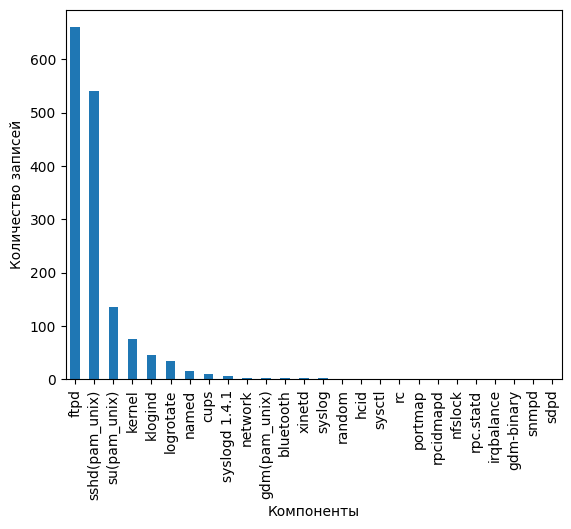

In [14]:
import matplotlib.pyplot as plt

components_distrib = log_df['Component'].value_counts()

components_distrib.plot(kind='bar')

plt.xlabel('Компоненты')
plt.ylabel('Количество записей')
plt.show()